# PageRank Project
## Zach Chase

In [3]:
import csv
import numpy as np

Many real-world systems can be represented as graphs (networks). These systems range from the internet, transportation grids, social media, and more. The PageRank algorithm was developed by Larry Page and Sergey Brin at Stanford University in 1996 to rank notes in a graph by importance, and thus create a ranking system most famously used by Google to rank web pages in their search engine history. This project I will implement the PageRank algorithm and use it to rank the nodes of networks.

## Create Class for PageRank Algorithm

An Adjacency Matrix (A) represents a directed graph which satisfies $A_{ij} = 1$ if node j links to node i and $A_{ij} = 0$ otherwise. The figure below shows the adjacency matrix for the image on the left.

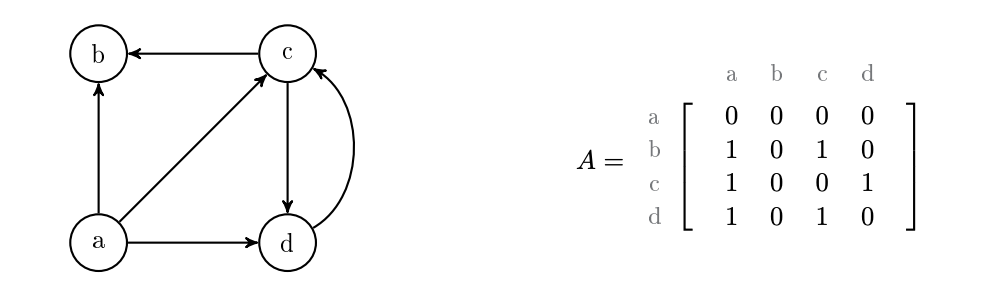

This model can be a potential model for a collection of webpages, where each may have a hyperlink to any other page. Note that each node represents a webpage and each edge represents a hyperlink. To prepare for a proper implementation of the PageRank algorithm, we must first avoid sinks by modifying each one so that the each sink has an edge added to every node in the graph. This means users on a page with no links can start over by selecting a random webpage. The example below demonstrates this situation.

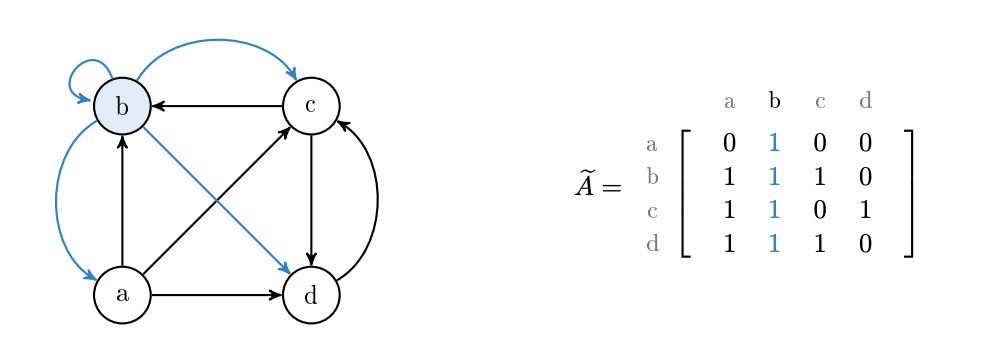

Now we will implement the algorithm, which can be explained in the following: !!!!!!!

In [4]:
class DiGraph:
    """A class for representing directed graphs via their adjacency matrices.

    Attributes:
        (fill this out after completing DiGraph.__init__().) ##############################################
    """

    def __init__(self, A, labels=None):
        """Modify A so that there are no sinks in the corresponding graph,
        then calculate Ahat. Save Ahat and the labels as attributes.

        Parameters:
            A ((n,n) ndarray): the adjacency matrix of a directed graph.
                A[i,j] is the weight of the edge from node j to node i.
            labels (list(str)): labels for the n nodes in the graph.
                If None, defaults to [0, 1, ..., n-1].
        """
        
        #Find size of A
        self.m, self.n = A.shape

        #Modify so there are no sinks
        for i in range(self.n):
            if np.count_nonzero(A[0:,i]) == 0:
                A[0:,i] = 1
                
        #Normalize
        A = A.astype(float)
        for i in range(self.n):
            A[0:,i] = A[0:,i]/np.sum(A[0:,i])
        
        #Assign A as an attribute
        self.ABar = A
        
        #Raise value error if labels is wrong size
        if labels is not None and len(labels) != self.n:
            raise ValueError("Labels have the wrong size")
        
        #If no labels assigned, assign them and store as an attribute
        if labels is None:
            labels = [i for i in range(self.n)]
        self.labels = labels
        

    # Problem 2
    def linsolve(self, epsilon=0.85):
        """Compute the PageRank vector using the linear system method.

        Parameters:
            epsilon (float): the damping factor, between 0 and 1.

        Returns:
            dict(str -> float): A dictionary mapping labels to PageRank values.
        """
    
        #Find A
        A = np.eye(self.n) - (epsilon*self.ABar)
        
        #Find b
        b = ((1-epsilon)/self.n) * np.ones(self.n) 
        
        #solve for p
        p = np.linalg.solve(A,b)
        
        #convert to dictionary
        PageRankDict = {self.labels[i]:p[i] for i in range(self.n)}
        
        return PageRankDict

    # Problem 2
    def eigensolve(self, epsilon=0.85):
        """Compute the PageRank vector using the eigenvalue method.
        Normalize the resulting eigenvector so its entries sum to 1.

        Parameters:
            epsilon (float): the damping factor, between 0 and 1.

        Return:
            dict(str -> float): A dictionary mapping labels to PageRank values.
        """
        
        #Calculate B
        B = (epsilon * self.ABar) + (((1 - epsilon)/self.n)*np.ones((self.n,self.n)))
        
        #Find eigenvalues and eigenvectors
        eigs = np.linalg.eig(B)
        
        #Determine eigenvalue associated with eigenvalue of 1
        p = eigs[1][:,0]
        
        #Determine the Page Rank vector and normalize
        PR_Vector = p/np.linalg.norm(p, ord=1)
        
        #Convert to dictionary using the labels
        PageRankDict = {self.labels[i]:PR_Vector[i] for i in range(self.n)}
        
        return(PageRankDict)


    # Problem 2
    def itersolve(self, epsilon=0.85, maxiter=100, tol=1e-12):
        """Compute the PageRank vector using the iterative method.

        Parameters:
            epsilon (float): the damping factor, between 0 and 1.
            maxiter (int): the maximum number of iterations to compute.
            tol (float): the convergence tolerance.

        Return:
            dict(str -> float): A dictionary mapping labels to PageRank values.
        """
        
        #Initialize p(0)
        p_0 = np.ones(self.n) * (1/self.n)
        
        #Iterate until maxiter is reached
        for i in range(maxiter):
            
            #Find p(t+1)
            p_1 = ((epsilon * self.ABar) @ p_0) + (((1-epsilon)/self.n)*np.ones(self.n))
            
            #Stop if difference is less than tol
            if np.linalg.norm((p_1-p_0), ord=1) < tol:
                break
            
            p_0 = p_1
        
        #convert to dictionary using the labels
        PageRankDict = {self.labels[i]:p_1[i] for i in range(self.n)}
        
        return(PageRankDict)


In [5]:
# Problem 3
def get_ranks(d):
    """Construct a sorted list of labels based on the PageRank vector.

    Parameters:
        d (dict(str -> float)): a dictionary mapping labels to PageRank values.

    Returns:
        (list) the keys of d, sorted by PageRank value from greatest to least.
    """
    
    #Find keys and values and put into a list
    keys = list(d.keys())
    values = list(d.values())
    
    #Sort keys from greatest to smallest
    values.sort(reverse=True)
    
    #Find keys associated from greatest to smallest
    mylist = []
    for i in values:
        for j in keys:
            if d[j] == i and j not in mylist:
                mylist.append(j)
                break
    
    return mylist

In [6]:
# Problem 4
def rank_websites(filename="web_stanford.txt", epsilon=0.85):
    """Read the specified file and construct a graph where node j points to
    node i if webpage j has a hyperlink to webpage i. Use the DiGraph class
    and its itersolve() method to compute the PageRank values of the webpages,
    then rank them with get_ranks().

    Each line of the file has the format
        a/b/c/d/e/f...
    meaning the webpage with ID 'a' has hyperlinks to the webpages with IDs
    'b', 'c', 'd', and so on.

    Parameters:
        filename (str): the file to read from.
        epsilon (float): the damping factor, between 0 and 1.

    Returns:
        (list(str)): The ranked list of webpage IDs.
    """
    
    #Define list, set, and dictionary
    data = []
    labels = set()
    mydictionary = dict()
    
    #Open file
    with open(filename) as f:
        
        #Read in lines and split at /
        for line in f.readlines():
            line = line.strip().split('/')
            
            #Add to a list of lists
            data.append(line)
            for label in line:
                labels.add(label)
        labels = sorted(labels)
        
        #Update dictionary
        for i in range(len(labels)):
            mydictionary[labels[i]] = i
            
        #Initialize the Adjacency Matrix
        array = np.zeros((len(labels),len(labels)))
        
        #Complete the matrix
        for line in data:
            i = mydictionary[line[0]]
            for label in line[1:]:
                j = mydictionary[label]
                array[j][i] += 1
                
    #Run through get_ranks
    return get_ranks(DiGraph(array,labels).itersolve(epsilon=epsilon))


In [7]:
# Problem 5
def rank_ncaa_teams(filename, epsilon=0.85):
    """Read the specified file and construct a graph where node j points to
    node i with weight w if team j was defeated by team i in w games. Use the
    DiGraph class and its itersolve() method to compute the PageRank values of
    the teams, then rank them with get_ranks().

    Each line of the file has the format
        A,B
    meaning team A defeated team B.

    Parameters:
        filename (str): the name of the data file to read.
        epsilon (float): the damping factor, between 0 and 1.

    Returns:
        (list(str)): The ranked list of team names.
    """
    #Open file and read in data
    with open(filename, 'r') as f:
        reader = csv.reader(f)
        headers = next(reader)
        data = list(reader)
        data = np.array(data)
    
    #find list of winners and losers
    winners = data[0:,0]
    losers = data[0:,1]
    
    
    #Note that the data collected includes the NCAA Tournament
    #Remove the 67 Tournament games to compare predication and actual tournament
    #winners = data[0:len(data)-67,0]
    #losers = data[0:len(data)-67,1]
    
    #Create the entire list of teams
    teams = []
    for x in winners:
        if x not in teams:
            teams.append(x)
    for y in losers:
        if y not in teams:
            teams.append(y)

    #Initialize the Adjacency Matrix
    A = np.zeros((len(teams),len(teams)))
    
    #Fill in the matrix
    counter = 0
    for i in losers:
        for _ in teams:
            if _ == i:
                lostTo = winners[counter]
                x = teams.index(i)
                y = teams.index(lostTo)
                A[y,x] += 1        
        counter += 1
    
    #Determine page rank from previous formula's
    tournament = DiGraph(A, labels = teams)
    bestTeams = get_ranks(tournament.itersolve(epsilon=epsilon))
    
    return bestTeams

In [10]:
rank_ncaa_teams("ncaa2010.csv")

['UConn',
 'Kentucky',
 'Louisville',
 'Notre Dame',
 'Florida',
 'BYU',
 "St. John's (NY)",
 'Kansas',
 'VCU',
 'Syracuse',
 'Pitt',
 'Ohio State',
 'UNC',
 'West Virginia',
 'Butler',
 'Duke',
 'Texas',
 'Marquette',
 'San Diego State',
 'Wisconsin',
 'Purdue',
 'Kansas State',
 'Georgetown',
 'Arizona',
 'Tennessee',
 'Vanderbilt',
 'UCLA',
 'Cincinnati',
 'Old Dominion',
 'Villanova',
 'New Mexico',
 'Washington',
 'Florida State',
 'Alabama',
 'Richmond',
 'Colorado',
 'Illinois',
 'George Mason',
 'Memphis',
 'USC',
 'Michigan State',
 'Virginia Tech',
 'Texas A&M',
 'Gonzaga',
 'Georgia',
 'Penn State',
 'Xavier',
 'UNLV',
 'UCF',
 'Missouri',
 'Ole Miss',
 'Alabama-Birmingham',
 'Wichita State',
 'Minnesota',
 'Washington State',
 'Michigan',
 'Temple',
 'Drexel',
 'Clemson',
 'Marshall',
 'Oklahoma State',
 'Valparaiso',
 'Milwaukee',
 "Saint Mary's (CA)",
 'Morehead State',
 'Arkansas',
 'East Carolina',
 'Nebraska',
 'Oregon',
 'Mississippi State',
 'Seton Hall',
 'Dayton',


In [12]:
rank_websites()

['98595',
 '32791',
 '28392',
 '77323',
 '92715',
 '26083',
 '130094',
 '99464',
 '12846',
 '106064',
 '332',
 '31328',
 '86049',
 '123900',
 '74923',
 '119538',
 '90571',
 '116900',
 '139197',
 '114623',
 '15672',
 '20283',
 '108608',
 '136623',
 '6213',
 '56800',
 '62259',
 '67827',
 '64104',
 '96254',
 '82752',
 '203109',
 '178606',
 '24083',
 '217557',
 '68912',
 '41471',
 '203100',
 '19894',
 '177473',
 '203696',
 '121480',
 '268900',
 '246911',
 '146603',
 '10984',
 '84478',
 '182230',
 '210258',
 '110923',
 '147255',
 '185201',
 '102329',
 '178003',
 '188707',
 '197440',
 '208254',
 '228036',
 '247003',
 '199855',
 '230247',
 '110520',
 '112786',
 '121418',
 '101455',
 '41677',
 '66498',
 '63712',
 '84094',
 '88621',
 '35759',
 '61413',
 '17101',
 '55398',
 '32789',
 '51075',
 '21554',
 '72982',
 '104202',
 '1662',
 '94657',
 '4889',
 '48096',
 '81525',
 '11433',
 '26918',
 '79322',
 '237162',
 '132956',
 '79383',
 '264536',
 '31597',
 '76236',
 '209406',
 '215281',
 '253851',
 

https://acme.byu.edu/00000179-afb2-d74f-a3ff-bfbb15980000/pagerank19-pdf